In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F



In [2]:
transformations = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((128,128), antialias=True),
                                      transforms.Grayscale(num_output_channels=1)
                                      ])


dataset = datasets.ImageFolder(
    root = '/kaggle/input/labeled-chest-xray-images/chest_xray',
    transform = transformations
                    )

data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)


In [3]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.dense = nn.Linear(noise_dim, 4*4*256)
        self.bn0 = nn.BatchNorm1d(4*4*256)
        self.conv_t0 = nn.ConvTranspose2d(256, 256, kernel_size=3,
                                         stride=2, padding=1,
                                         output_padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv_t1 = nn.ConvTranspose2d(256, 128, kernel_size=3,
                                         stride=2, padding=1,
                                         output_padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv_t2 = nn.ConvTranspose2d(128, 64, kernel_size=3,
                                         stride=2, padding=1,
                                         output_padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv_t3 = nn.ConvTranspose2d(64, 32, kernel_size=3,
                                         stride=2, padding=1,
                                         output_padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.conv_t4 = nn.ConvTranspose2d(32, 1, kernel_size=3,
                                         stride=2, padding=1,
                                         output_padding=1)

        
    def forward(self, x):
        x = self.dense(x)
        x = F.selu(self.bn0(x))
        x = x.view(-1, 256, 4, 4)
        x = F.selu(self.bn1(self.conv_t0(x)))
        x = F.selu(self.bn2(self.conv_t1(x)))
        x = F.selu(self.bn3(self.conv_t2(x)))
        x = F.selu(self.bn4(self.conv_t3(x)))
        x = F.tanh(self.conv_t4(x))
        return x
    
    

        
        
generator = Generator(noise_dim=64)        

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv0 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv1 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.dense = nn.Linear(8*8*128, 1)
        self.dropout = nn.Dropout(0.4)
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.dropout(F.leaky_relu(self.conv0(x), 0.2))
        x = self.dropout(F.leaky_relu(self.conv1(x), 0.2))
        x = self.dropout(F.leaky_relu(self.conv2(x), 0.2))
        x = self.dropout(F.leaky_relu(self.conv3(x), 0.2))
        x = self.flatten(x)
        x = torch.sigmoid(self.dense(x))
        return x
        
        
discriminator = Discriminator()


In [5]:
from tqdm import tqdm
class GAN(nn.Module):
    def __init__(self, generator, discriminator, device):
        super(GAN, self).__init__()
        
        self.device = device
        self.generator = generator
        self.discriminator = discriminator
        self.gan = nn.Sequential(generator, discriminator)
        #self.d_optimizer = optim.RMSprop(self.discriminator.parameters())
        self.d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        #self.g_optimizer = optim.RMSprop(self.generator.parameters())
        self.g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        self.loss = nn.BCELoss()
        
        
    def train(self, data_loader, noise_dim, epochs):
        for i in range(epochs):
            #with tqdm(data_loader, unit="batch") as tepoch:
            #    tepoch.set_description(f"Epoch {i + 1}/{epochs}")
            for images_batch,_ in data_loader:

                #Phase-I
                images_batch = images_batch.to(self.device)
                batch_size = images_batch.shape[0]
                noise = torch.randn(batch_size, noise_dim, device=self.device)
                fake_images = self.generator(noise)
                mixed_images = torch.cat([fake_images, images_batch], axis=0)
                labels = torch.cat([torch.zeros(batch_size, device=self.device), torch.ones(batch_size, device=self.device)], dim=0).view(-1,1)

                self.discriminator.train()
                self.d_optimizer.zero_grad()
                self.d_loss = self.loss(self.discriminator(mixed_images), labels)
                #print(self.d_loss.item())

                self.d_loss.backward()
                self.d_optimizer.step()


                #Phase-II

                noise = torch.randn(batch_size, noise_dim, device=self.device)
                fake_labels = torch.ones(batch_size, device=self.device).view(-1,1)

                self.generator.train()
                self.g_optimizer.zero_grad()
                self.discriminator.eval()
                self.g_loss = self.loss(self.discriminator(self.generator(noise)), fake_labels)
                #print(self.g_loss.item())
                self.g_loss.backward()
                self.g_optimizer.step()

                #tepoch.set_postfix(d_loss=self.d_loss.item(), g_loss=self.g_loss.item())
            
            #self.show_generated_images()
            self.save('/kaggle/working/checkpointNewestbas')
            print(f'Epoch: {i}')
    
    
    def show_generated_images(self):
        noise = torch.randn(5, 100, device=self.device)
        images = self.generator(noise)
        n_cols = 5
        n_rows = (len(images) - 1) // n_cols + 1
        if images.shape[-1] == 1:
            images = np.squeeze(images, axis=-1)
        plt.figure(figsize=(n_cols * 2.5, n_rows * 2.5))  # Adjust the multiplier for larger images
        for index, image in enumerate(images):
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(image.permute(1, 2, 0).cpu().detach().numpy(), cmap="binary", interpolation="nearest")  # Adjust interpolation as needed
            plt.axis("off")
        plt.tight_layout()
        plt.show()
    
    
    def save(self, save_path):
        torch.save({
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'g_optimizer_state_dict': self.g_optimizer.state_dict(),
            'd_optimizer_state_dict': self.d_optimizer.state_dict(),
        }, save_path)
        
    def load(self, load_path):
        checkpoint = torch.load(load_path)
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        self.g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
        self.d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
                


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
noise_dim = 100
generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)
gan = GAN(generator, discriminator, device).to(device)

In [8]:
gan.load('/kaggle/input/nnnnnnn/checkpointNewestbas')

In [ ]:
gan.train(data_loader, noise_dim, epochs=350)

gan.show_generated_images()

In [16]:
for x in data_loader:
    break

x[0].shape

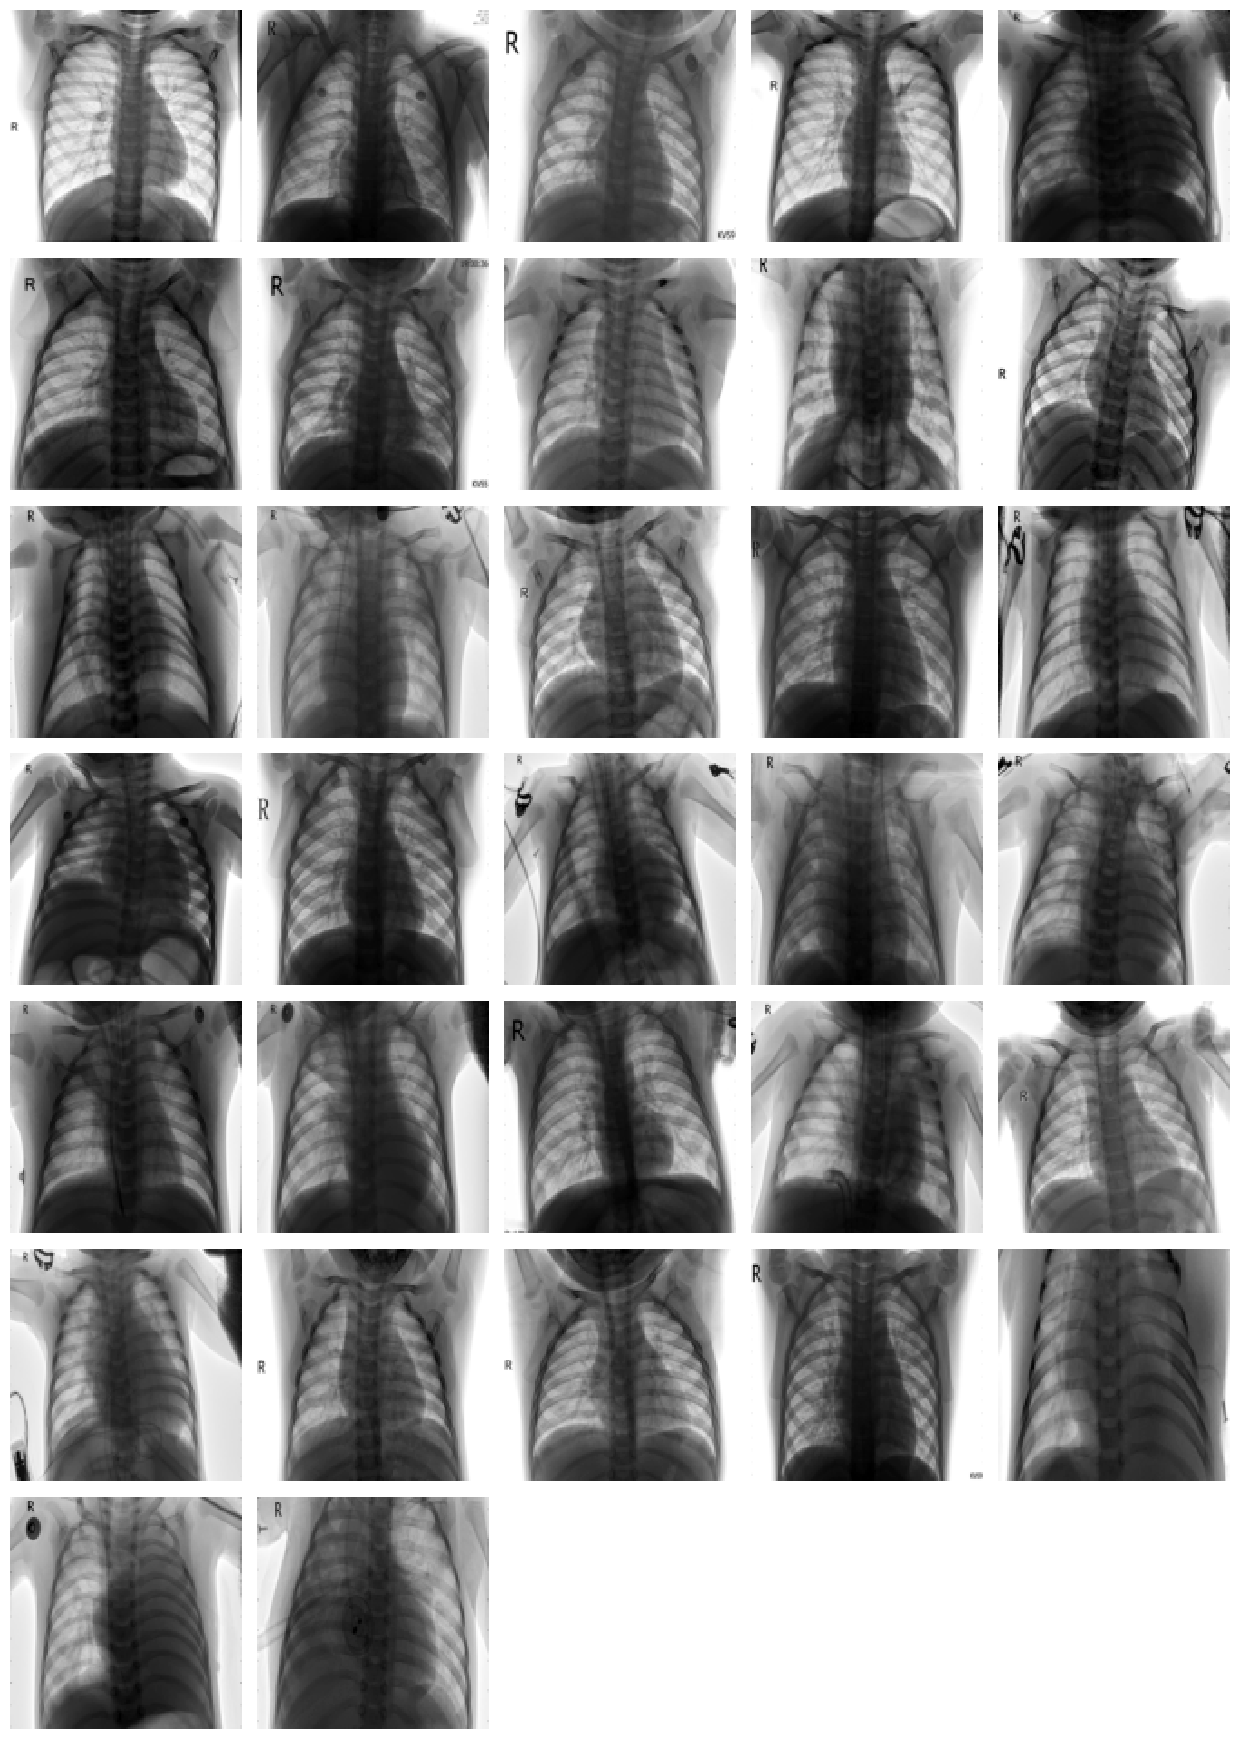

In [17]:
noise = torch.randn(10, 100, device=gan.device)
images = x[0][0:510]
n_cols = 5
n_rows = (len(images) - 1) // n_cols + 1
if images.shape[-1] == 1:
    images = np.squeeze(images, axis=-1)
plt.figure(figsize=(n_cols * 2.5, n_rows * 2.5))  # Adjust the multiplier for larger images
for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(image.permute(1, 2, 0).cpu().detach().numpy(), cmap="binary", interpolation="nearest")  # Adjust interpolation as needed
    plt.axis("off")
plt.tight_layout()
plt.show()

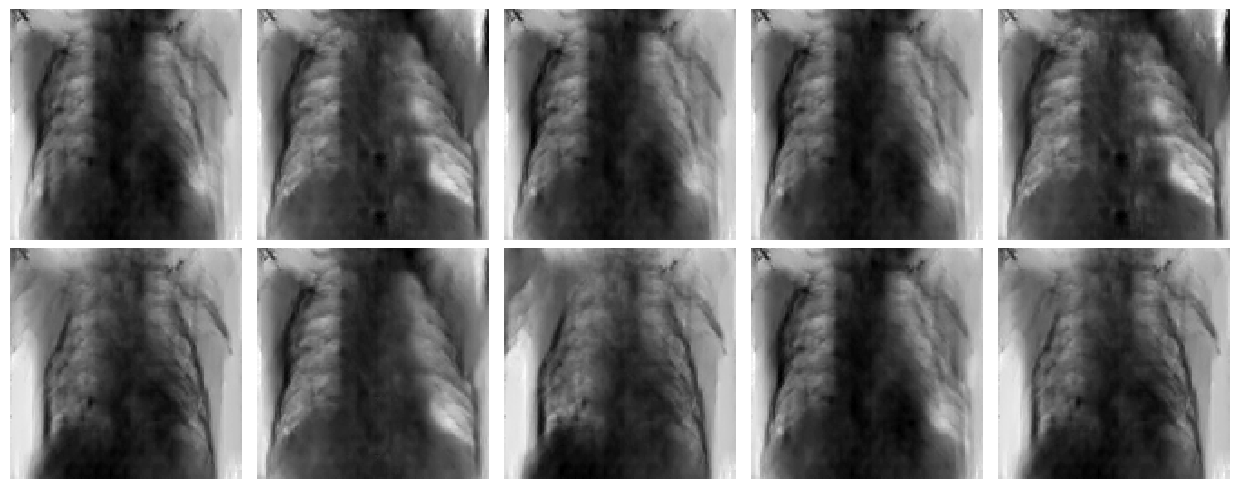

In [14]:
noise = torch.randn(10, 100, device=gan.device)
images = gan.generator(noise)
n_cols = 5
n_rows = (len(images) - 1) // n_cols + 1
if images.shape[-1] == 1:
    images = np.squeeze(images, axis=-1)
plt.figure(figsize=(n_cols * 2.5, n_rows * 2.5))  # Adjust the multiplier for larger images
for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(image.permute(1, 2, 0).cpu().detach().numpy(), cmap="binary", interpolation="nearest")  # Adjust interpolation as needed
    plt.axis("off")
plt.tight_layout()
plt.show()